In [1]:
# Import required dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import sys

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Import custom modules
import simulator

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1(np.linspace(0, 1, 10)))

In [2]:
tp = 2
dp = 8 
bs = 16
device_num = 320

sequence_length = 4383
decode_length = 1210

args = simulator.ModelArgs()
gpu_list = simulator.get_gpu_info('../device/gpu_info.csv', decoding_mode=False)

gemm_group_per_device = math.ceil(args.n_routed_experts / device_num)

In [3]:
time_ms = simulator.prefill_time(
    args,
    gpu_list['H800'],
    sequence_length,
    kv_cache_rate=0.563,
    tp_num=tp,
    dp_num=dp,
)

print(f"Prefill time: {time_ms} ms")

Prefill time: 302.0553242764904 ms


In [4]:
time_ms, throughput = simulator.decode_time(
    args,
    gpu_list['H800'],
    tp_num=4,
    bs_num=64,
    seq_len=sequence_length,
    decode_len=decode_length,
    gemm_group_per_device=gemm_group_per_device,
    device_num=device_num,
    print_flag=False,
)

print(f"Decode time: {time_ms} ms")
print(f"Throughput: {throughput} tokens/s")

Decode time: 17.85995941107182 ms
Throughput: 3583.4347955082617 tokens/s


In [5]:
total_time_ms = 0
for current_decode_length in range(decode_length):
    time_ms, _ = simulator.decode_time(
        args,
        gpu_list['H800'],
        tp_num=tp,
        bs_num=bs,
        seq_len=sequence_length + current_decode_length,
        decode_len=current_decode_length,
        gemm_group_per_device=gemm_group_per_device,
        device_num=device_num,
        print_flag=False,
    )
    total_time_ms += time_ms

print(f"Decode time: {total_time_ms} ms")

Decode time: 15405.610756165308 ms


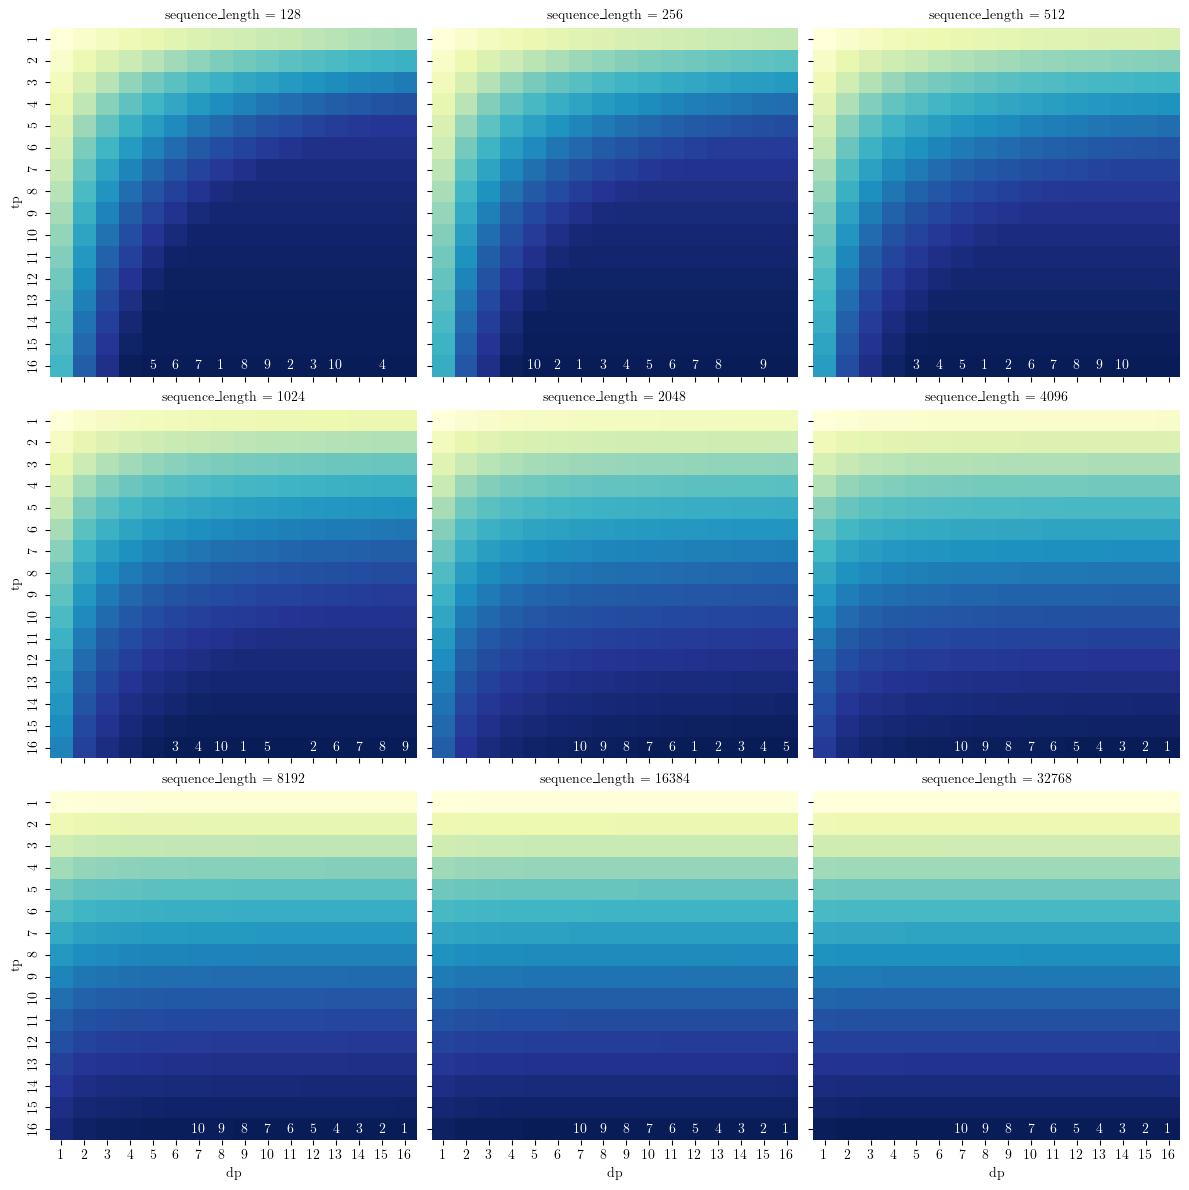

In [6]:
dp_list = list(range(1, 17))
tp_list = list(range(1, 17))
sequence_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

# collect results
results = []
for seq_len in sequence_lengths:
    for tp in tp_list:
        for dp in dp_list:
            time_ms = simulator.prefill_time(
                args,
                gpu_list['H800'],
                seq_len,
                kv_cache_rate=0.563,
                tp_num=tp,
                dp_num=dp,
            )
            throughput = seq_len * (1000.0 / time_ms)
            results.append({
                'tp': tp,
                'dp': dp,
                'sequence_length': seq_len,
                'throughput': throughput,
            })

# Build DataFrame
df = pd.DataFrame(results)

# faceted heatmaps
g = sns.FacetGrid(
    df,
    col="sequence_length",
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

def draw_heatmap(data, **kwargs):
    # pivot for this sequence length
    pivot = data.pivot(index="tp", columns="dp", values="throughput")
    ax = plt.gca()
    sns.heatmap(pivot, cbar=False, fmt=".1f", **kwargs)
    # find the top ten tp/dp in this subset
    top_ten = data.nlargest(10, 'throughput')
    
    # label the top ten tp/dp
    for rank, row in enumerate(top_ten.itertuples(), start=1):
        tp, dp = int(row.tp), int(row.dp)
        row_idx = list(pivot.index).index(tp)
        col_idx = list(pivot.columns).index(dp)
        ax.text(
            col_idx + 0.5, 
            row_idx + 0.5, 
            str(rank), 
            color='white', 
            ha='center', 
            va='center', 
            fontsize=10, 
            fontweight='bold'
        )

g.map_dataframe(draw_heatmap, cmap="YlGnBu")

for ax in g.axes.flat:
    ax.set_xlabel("dp")
    ax.set_ylabel("tp")

plt.show()

Configs by number of wins across lengths:
   tp  dp  win_count
4  16  16          4
1  16   8          2
0  16   7          1
2  16   9          1
3  16  12          1


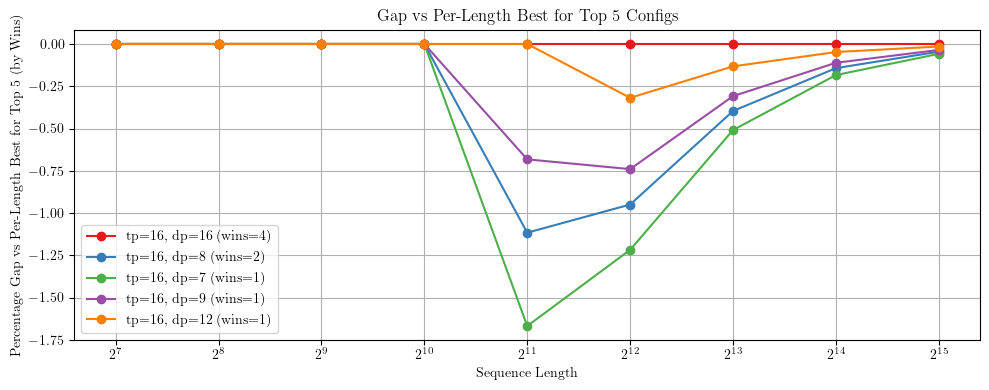

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Build DataFrame
df = pd.DataFrame(results)

# --- 1) “Winner count” metric ---
# find, for each sequence_length, the best throughput
idx = df.groupby('sequence_length')['throughput'].idxmax()
winners = df.loc[idx, ['tp','dp','sequence_length','throughput']]

# count wins per (tp,dp)
best_counts = (
    winners
    .groupby(['tp','dp'])
    .size()
    .reset_index(name='win_count')
    .sort_values('win_count', ascending=False)
)
print("Configs by number of wins across lengths:")
print(best_counts.head())

# pick top 5 configs
top5 = best_counts.head(5)

# prepare per-length-best lookup
per_len_best = winners.set_index('sequence_length')['throughput']

# --- plot gaps for each of the top 5 configs ---
plt.figure(figsize=(10,4))
for _, row in top5.iterrows():
    tp, dp, wins = int(row.tp), int(row.dp), int(row.win_count)
    series = (
        df[(df.tp==tp)&(df.dp==dp)]
        .set_index('sequence_length')['throughput']
    )
    # percentage gap vs per-length best
    pct_gap = (series - per_len_best) / per_len_best * 100.0
    plt.plot(
        pct_gap.index, pct_gap.values,
        marker='o',
        label=f"tp={tp}, dp={dp} (wins={wins})"
    )

plt.xscale('log', base=2)
plt.xlabel('Sequence Length')
plt.ylabel('Percentage Gap vs Per-Length Best for Top 5 (by Wins)')
plt.title('Gap vs Per-Length Best for Top 5 Configs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Configs closest on average to per-length optimum (lowest mean % dev):
     tp  dp  mean_pct_dev
255  16  16  1.205770e-14
254  16  15  1.144278e-02
253  16  14  2.450695e-02
252  16  13  3.956343e-02
251  16  12  5.710558e-02


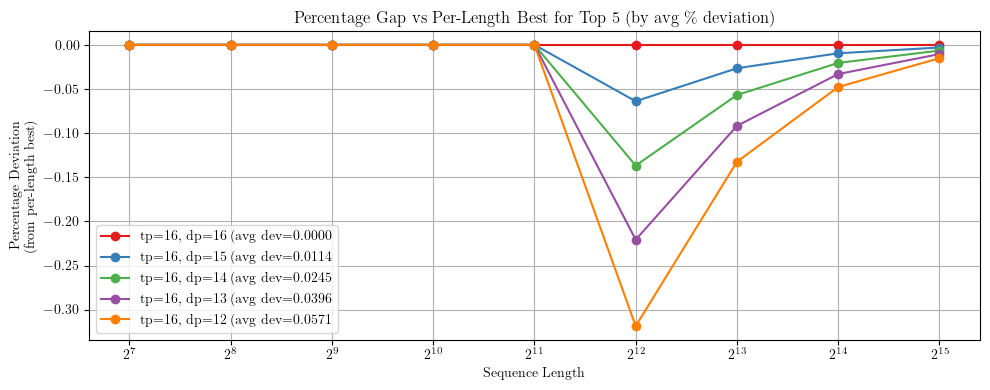

In [8]:
# --- 2) Average % deviation metric ---
per_len_best = winners.set_index('sequence_length')['throughput']

# join back so each row knows the per-length best
df2 = (
    df
    .set_index('sequence_length')
    .join(per_len_best.rename('best_for_len'), how='left')
    .reset_index()
)

# compute % deviation from per-length best: positive means underperform
df2['pct_dev'] = (
    (df2['best_for_len'] - df2['throughput'])
    / df2['best_for_len']
) * 100.0

# average that deviation per (tp,dp)
avg_dev = (
    df2
    .groupby(['tp','dp'])['pct_dev']
    .mean()
    .reset_index(name='mean_pct_dev')
    .sort_values('mean_pct_dev')
)

print("\nConfigs closest on average to per-length optimum (lowest mean % dev):")
print(avg_dev.head())

# pick top 5 configs by lowest mean deviation
top5 = avg_dev.head(5)

# plot % deviation for each of the top 5:
plt.figure(figsize=(10,4))
for _, row in top5.iterrows():
    tp, dp, mean_dev = int(row.tp), int(row.dp), row.mean_pct_dev
    series = (
        df[(df.tp==tp)&(df.dp==dp)]
        .set_index('sequence_length')['throughput']
    )
    pct_gap = (series - per_len_best) / per_len_best * 100.0
    # But since pct_dev was defined as (best - actual)/best, if you want the same sign:
    pct_gap = pct_gap

    plt.plot(
        pct_gap.index, pct_gap.values,
        marker='o',
        label=f"tp={tp}, dp={dp} (avg dev={mean_dev:.4f}%)"
    )

plt.xscale('log', base=2)
plt.xlabel('Sequence Length')
plt.ylabel('Percentage Deviation\n(from per-length best)')
plt.title('Percentage Gap vs Per-Length Best for Top 5 (by avg \\% deviation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()